# Tensor Completion

Reference tensor is generated from Gaussian Process (GP)

1. Build GP model of the reference tensor
2. Perform tensor completion using random init
3. Perform tensor completion using TT-cross reapproximation of GP model as init

In [1]:
from __future__ import print_function

import numpy as np

%matplotlib inline

from tqdm import tqdm

import pickle
import numpy as np
from matplotlib import interactive, pyplot

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


import GPy

import fenics as fe
from hyperopt import fmin, tpe, hp
import tt
from tt.cross import rect_cross


import tensorflow as tf
import t3f
tf.set_random_seed(0)
np.random.seed(0)

In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=DataConversionWarning)


def generate_exact_gp_model(d, random_state=None, ARD=False):
    if random_state is None:
        random_state = np.random.RandomState()

    size = [5] * d
    train_size = min(np.prod(size), 5000)

    sigma = random_state.rand(d) * 0.5 + 0.1
    if ARD:
        kernel = GPy.kern.RBF(d, variance=1, lengthscale=sigma, ARD=True)
    else:
        kernel = GPy.kern.RBF(d, variance=1, lengthscale=sigma[0], ARD=False)
    
    grid_1d = [np.linspace(0, 1, k) for k in size]

    x_grid = np.meshgrid(*grid_1d)
    x_grid = np.hstack((x_grid[i].reshape(-1, 1) for i in range(d)))

    # take subsample if number of points in grid is too large
    x_train = x_grid
    if x_grid.shape[0] > train_size:
        p = np.random.permutation(x_grid.shape[0])
        x_train = x_grid[p[:train_size]]

    y_train = np.random.multivariate_normal(np.zeros(x_train.shape[0]),
                                            kernel.K(x_train, x_train),
                                            size=[1]).reshape(-1, 1)


    model_gp = GPy.models.GPRegression(x_train, y_train, kernel)
    model_gp.kern.lengthscale.fix()
    model_gp.optimize(messages=False)
    return model_gp

def tensor_element(model_gp, x, size=None):
    if size is not None:
        size = np.array(size)
    x = x / (size.reshape(1, -1) - 1)
    
    y = model_gp.predict(x)
    if len(y) == 2:
        return y[0]
    return y


def get_data(model_gp, n, size, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState()
        
    x = np.empty((n, len(size)), dtype=float)
    for i, s in enumerate(size):
        x[:, i] = random_state.randint(s, size=(n, ))

    y = tensor_element(model_gp, x, size)
    x = x / (np.array(size).reshape(1, -1) - 1)
    return x, y


def multiidx2idx(multiidx, size):
    idx = 0
    d = len(size)
    for i, s in enumerate(size[::-1]):
        idx += multiidx[d - i - 1] * s**i
    return idx


def idx2multiidx(idx, size):
    d = len(size)
    idx_copy = np.copy(idx)
    multiidx = np.empty((idx.shape[0], d), dtype=int)

    for i, s in enumerate(size[::-1]):
        multiidx[:, d - i - 1] = idx_copy % s
        idx_copy = (idx_copy - multiidx[:, d - i -1]) // s
        
    return multiidx


def calc_mse(y, x_tt, multiidx):
    error = 0
    for i, index in enumerate(multiidx):
        error += (y[i] - x_tt[index])**2

    error /= len(multiidx)
    return error[0]


def calc_ttcross_errors(model_gp, x):
    test_idx = random_state.randint(10**d, size=(10000))
    multiidx = idx2multiidx(test_idx, size)
    x_test = multiidx / (np.asarray(size) - 1)

    y_test, _ = model_gp.predict(x_test)
    mse = calc_mse(y_test, x, multiidx)
    return mse, np.sqrt(mse) / y_test.std()

### Define loss function

In [3]:
def build_graph(x_init, y_train, train_idx, y_test, test_idx):    
    estimated = t3f.get_variable('estimated', initializer=x_init)

    # Loss
    estimated_vals_train = t3f.gather_nd(estimated, train_idx)
    loss = tf.reduce_mean((estimated_vals_train - y_train) ** 2)
    
    estimated_vals_test = t3f.gather_nd(estimated, test_idx)    
    test_loss = tf.reduce_mean((estimated_vals_test - y_test)**2)
    return loss, test_loss, estimated

#### SGD optimization
The simplest way to solve the optimization problem is Stochastic Gradient Descent: let TensorFlow differentiate the loss w.r.t. the factors (cores) of the TensorTrain decomposition of the estimated tensor and minimize the loss with your favourite SGD variation.

In [4]:
def train(loss, test_loss, estimated_tensor, early_stopping_rounds=50):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    step = optimizer.minimize(loss)

    rounds_without_improvement = 0
    best_test_loss = np.inf
    best_loss_round = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_hist = []
        test_loss_hist = []

        for i in range(350):
            _, loss_v = sess.run([step, loss])
            loss_hist.append(loss_v)
            test_loss_hist.append(sess.run(test_loss))

            if best_test_loss > test_loss_hist[-1]:
                best_test_loss = test_loss_hist[-1]
                best_loss_round = i
                rounds_without_improvement = 0
            else:
                rounds_without_improvement += 1
                
            if rounds_without_improvement >= early_stopping_rounds:
                break
        
        cores = sess.run(estimated_tensor.tt_cores)
        estimated_tensor_ttpy = tt.core.vector.tensor.from_list(cores)
        
    pyplot.figure()
    pyplot.plot(loss_hist, label='Train')
    pyplot.plot(test_loss_hist, label='Test')
    pyplot.legend()
    pyplot.show()
        
    return loss_hist, test_loss_hist, estimated_tensor_ttpy

### Random init

In [5]:
def tensor_completion_rand_init(y_train, train_idx, y_test, test_idx, size, figure=None):
    tf.reset_default_graph()

    d = train_idx.shape[1]
    x_init = t3f.random_tensor(size, tt_rank=2)

    loss, test_loss, estimated = build_graph(x_init, y_train, train_idx, y_test, test_idx)
    loss_hist, test_loss_hist, estimated_ttpy = train(loss, test_loss, estimated)

    error_test = calc_mse(y_test, estimated_ttpy, test_idx)
    error_train = calc_mse(y_train, estimated_ttpy, train_idx)
    
    return error_train, error_test, estimated_ttpy

### GP+TT-cross as init

In [10]:
def tensor_completion_gp_init(x_train, y_train, train_idx, y_test, test_idx, size):
    r = 2
    d = x_train.shape[1]

    kernel = GPy.kern.RBF(d)
    gp = GPy.models.GPRegression(x_train, y_train, kernel)
    gp.optimize()

    x0 = tt.rand(size, d, r)
    x_gp = rect_cross.cross(lambda x: gp.predict(x)[0], x0, nswp=2, kickrank=1, rf=2)

    tf.reset_default_graph()

    x_gp_cores = tt.core.vector.tensor.to_list(x_gp)
    x_gp_cores = [core.astype(np.float32) for core in x_gp_cores]
    x_init = t3f.TensorTrain(x_gp_cores, size, x_gp.r)

    loss, test_loss, estimated = build_graph(x_init, y_train, train_idx, y_test, test_idx)
    loss_hist, test_loss_hist, estimated_ttpy = train(loss, test_loss, estimated)

    error_test = calc_mse(y_test, estimated_ttpy, test_idx)
    error_train = calc_mse(y_train, estimated_ttpy, train_idx)
    
    return error_train, error_test, gp, x_gp

Dim: 3
Run #0


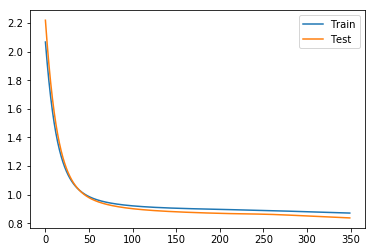

swp: 0/1 er_rel = 1.3e+01 er_abs = 3.7e+01 erank = 4.0 fun_eval: 300
swp: 1/1 er_rel = 5.2e-11 er_abs = 1.5e-10 erank = 6.0 fun_eval: 1000


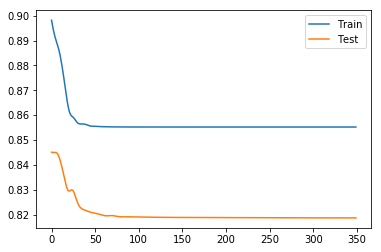

Run #1


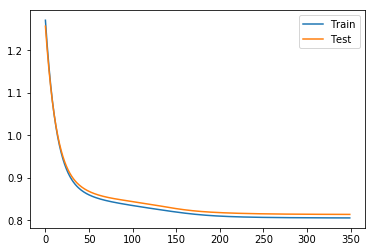

swp: 0/1 er_rel = 1.6e+01 er_abs = 4.5e+01 erank = 4.0 fun_eval: 300
swp: 1/1 er_rel = 5.8e-10 er_abs = 1.6e-09 erank = 6.0 fun_eval: 1000


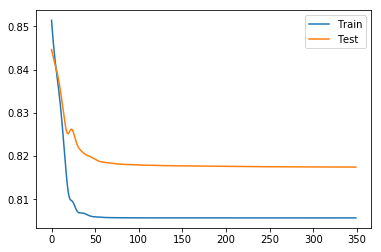

Run #2


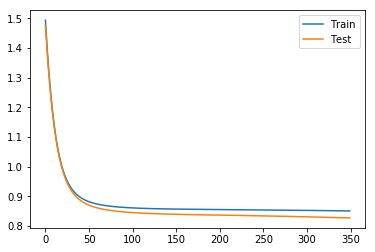

swp: 0/1 er_rel = 1.7e+01 er_abs = 4.8e+01 erank = 4.0 fun_eval: 300
swp: 1/1 er_rel = 9.0e-11 er_abs = 2.5e-10 erank = 6.0 fun_eval: 1000


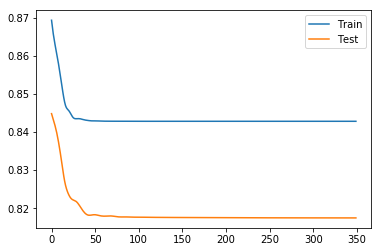

Run #3


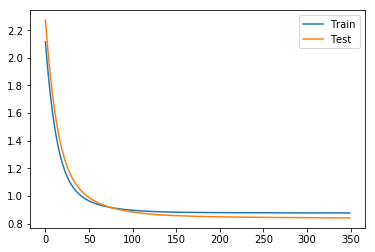

swp: 0/1 er_rel = 2.3e+01 er_abs = 6.4e+01 erank = 4.0 fun_eval: 300
swp: 1/1 er_rel = 7.7e-11 er_abs = 2.2e-10 erank = 6.0 fun_eval: 1000


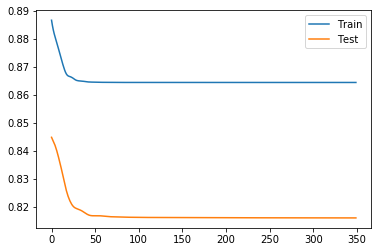

Run #4


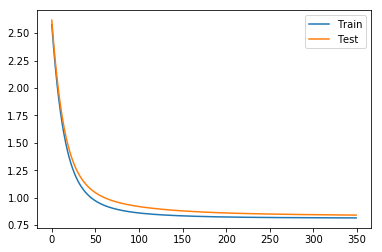

swp: 0/1 er_rel = 1.9e+01 er_abs = 5.4e+01 erank = 4.0 fun_eval: 300
swp: 1/1 er_rel = 8.4e-11 er_abs = 2.4e-10 erank = 6.0 fun_eval: 1000


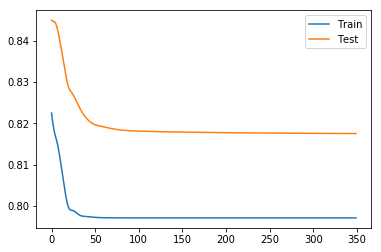

Run #5


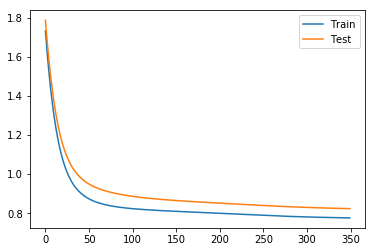

swp: 0/1 er_rel = 2.0e+01 er_abs = 5.6e+01 erank = 4.0 fun_eval: 300
swp: 1/1 er_rel = 1.3e-10 er_abs = 3.6e-10 erank = 6.0 fun_eval: 1000


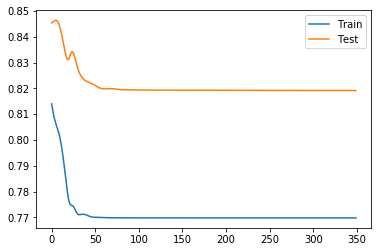

Run #6


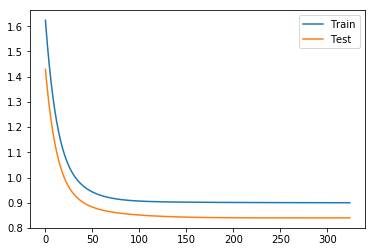

swp: 0/1 er_rel = 1.3e+01 er_abs = 3.6e+01 erank = 4.0 fun_eval: 300
swp: 1/1 er_rel = 6.7e-11 er_abs = 1.9e-10 erank = 6.0 fun_eval: 1000


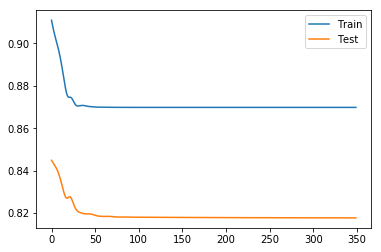

Run #7


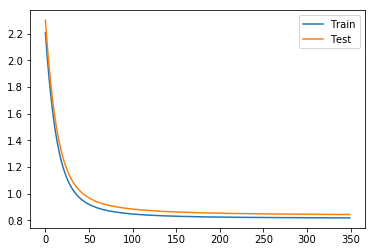

swp: 0/1 er_rel = 1.6e+01 er_abs = 4.4e+01 erank = 4.0 fun_eval: 300
swp: 1/1 er_rel = 1.2e-10 er_abs = 3.4e-10 erank = 6.0 fun_eval: 1000


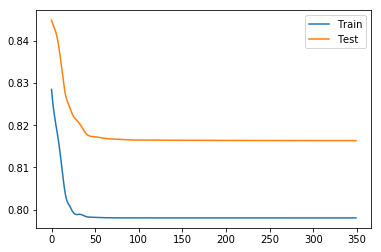

Run #8


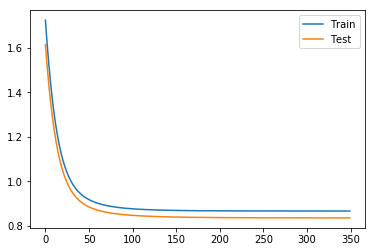

swp: 0/1 er_rel = 2.3e+01 er_abs = 6.5e+01 erank = 4.0 fun_eval: 300
swp: 1/1 er_rel = 2.8e-11 er_abs = 7.9e-11 erank = 6.0 fun_eval: 1000


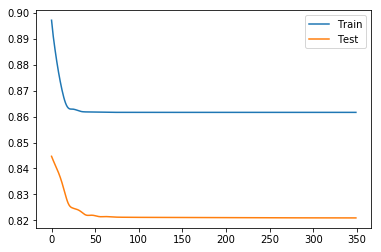

Run #9


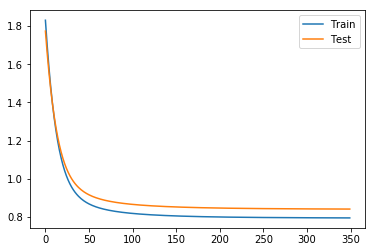

swp: 0/1 er_rel = 3.0e+01 er_abs = 8.4e+01 erank = 4.0 fun_eval: 300
swp: 1/1 er_rel = 2.9e-11 er_abs = 8.0e-11 erank = 6.0 fun_eval: 1000


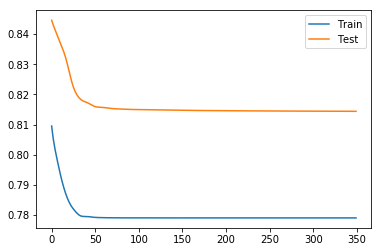

Rand:  0.8402327511501133 0.04251090355821506
GP:    0.8243746864855896 0.03629793248522556
Rand:  0.8356555670318249 0.013767801532270153
GP:    0.814707648512584 0.003296722602452215
Dim: 4
Run #0


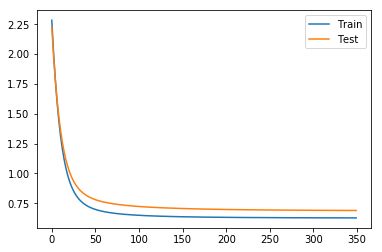

swp: 0/1 er_rel = 9.5e+01 er_abs = 2.8e+02 erank = 4.0 fun_eval: 480
swp: 1/1 er_rel = 1.5e-02 er_abs = 4.3e-02 erank = 6.0 fun_eval: 1680


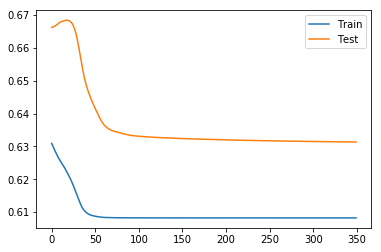

Run #1


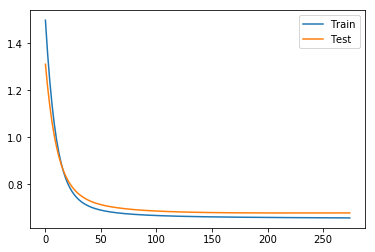

swp: 0/1 er_rel = 6.8e+01 er_abs = 2.1e+02 erank = 4.0 fun_eval: 480
swp: 1/1 er_rel = 1.8e-02 er_abs = 5.5e-02 erank = 6.0 fun_eval: 1680


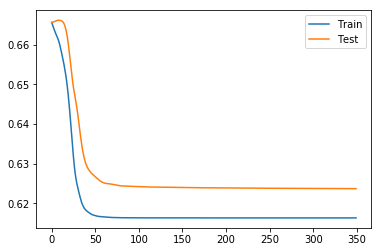

Run #2


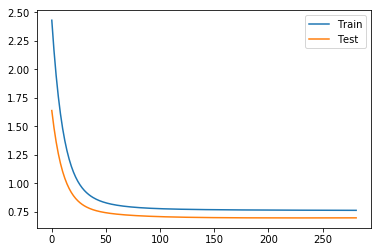

swp: 0/1 er_rel = 1.1e+02 er_abs = 3.6e+02 erank = 4.0 fun_eval: 480
swp: 1/1 er_rel = 2.0e-02 er_abs = 6.4e-02 erank = 6.0 fun_eval: 1680


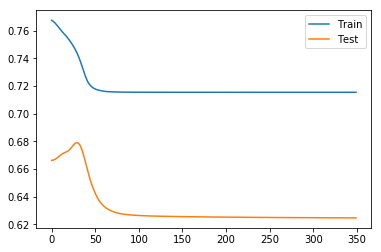

Run #3


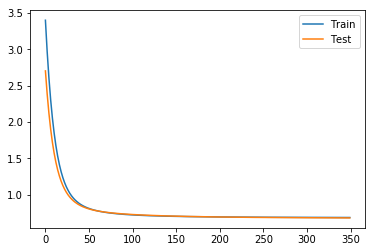

swp: 0/1 er_rel = 7.2e+01 er_abs = 2.4e+02 erank = 4.0 fun_eval: 480
swp: 1/1 er_rel = 3.3e-02 er_abs = 1.1e-01 erank = 6.0 fun_eval: 1680


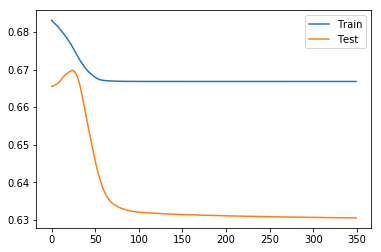

Run #4


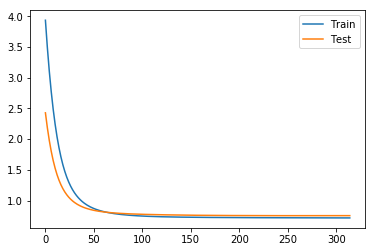

swp: 0/1 er_rel = 8.0e+01 er_abs = 2.4e+02 erank = 4.0 fun_eval: 480
swp: 1/1 er_rel = 3.1e-02 er_abs = 8.9e-02 erank = 6.0 fun_eval: 1680


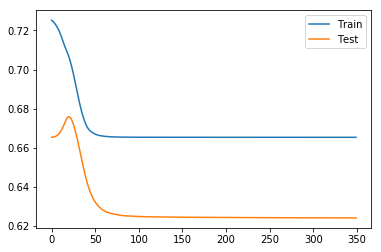

Run #5


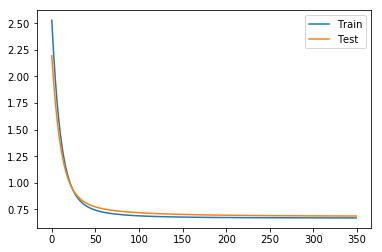

swp: 0/1 er_rel = 1.6e+02 er_abs = 4.9e+02 erank = 4.0 fun_eval: 480
swp: 1/1 er_rel = 1.1e-02 er_abs = 3.6e-02 erank = 6.0 fun_eval: 1680


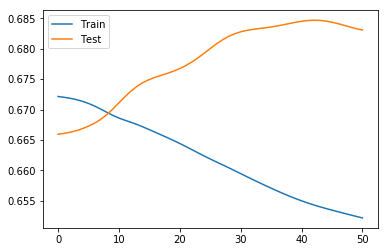

Run #6


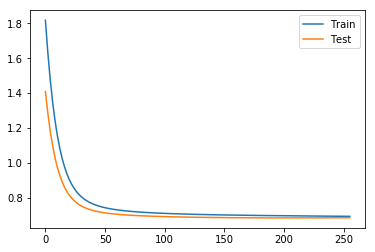

swp: 0/1 er_rel = 6.8e+01 er_abs = 2.4e+02 erank = 4.0 fun_eval: 480
swp: 1/1 er_rel = 1.7e-02 er_abs = 5.8e-02 erank = 6.0 fun_eval: 1680


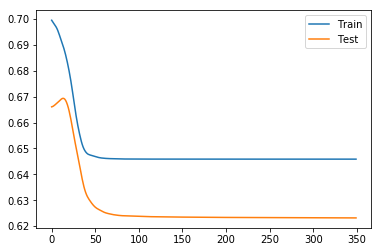

Run #7


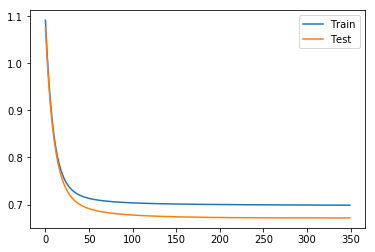

swp: 0/1 er_rel = 7.1e+01 er_abs = 2.3e+02 erank = 4.0 fun_eval: 480
swp: 1/1 er_rel = 4.2e-02 er_abs = 1.4e-01 erank = 6.0 fun_eval: 1680


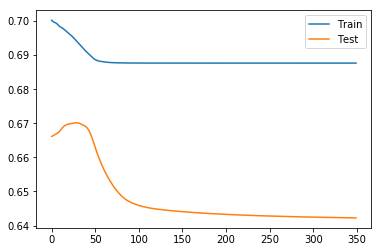

Run #8


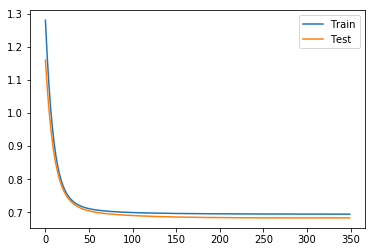

swp: 0/1 er_rel = 7.6e+01 er_abs = 2.5e+02 erank = 4.0 fun_eval: 480
swp: 1/1 er_rel = 1.3e-02 er_abs = 4.2e-02 erank = 6.0 fun_eval: 1680


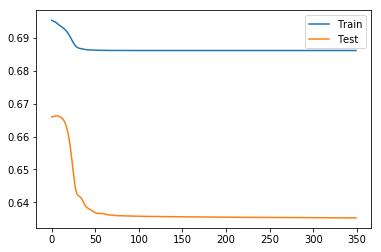

Run #9


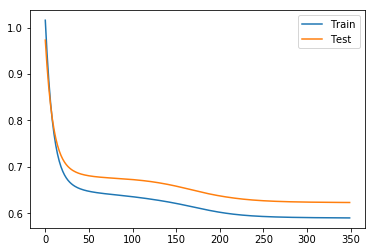

swp: 0/1 er_rel = 8.8e+01 er_abs = 2.6e+02 erank = 4.0 fun_eval: 480
swp: 1/1 er_rel = 1.6e-02 er_abs = 4.7e-02 erank = 6.0 fun_eval: 1680


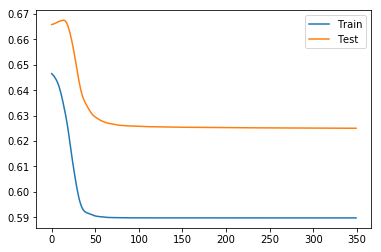

Rand:  0.6805337504624108 0.04685228892040159
GP:    0.65178595173128 0.03762641387344868
Rand:  0.6860701750593663 0.031352233472291886
GP:    0.6350469470720701 0.01833090193677115
Dim: 5
Run #0


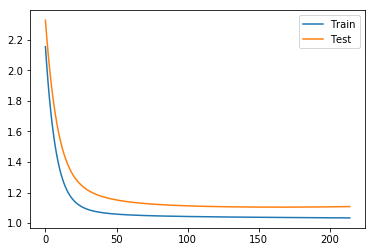

swp: 0/1 er_rel = 1.5e+02 er_abs = 9.4e+02 erank = 4.0 fun_eval: 660
swp: 1/1 er_rel = 5.2e-01 er_abs = 3.7e+00 erank = 6.0 fun_eval: 2360


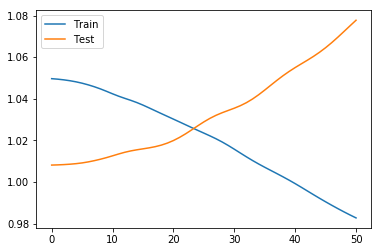

Run #1


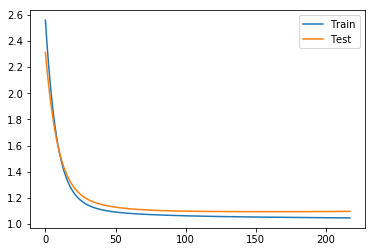

swp: 0/1 er_rel = 1.1e+02 er_abs = 7.7e+02 erank = 4.0 fun_eval: 660
swp: 1/1 er_rel = 4.6e-01 er_abs = 3.1e+00 erank = 6.0 fun_eval: 2360


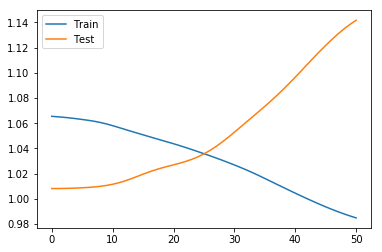

Run #2


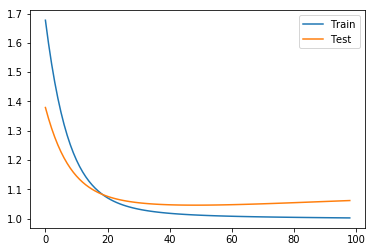

swp: 0/1 er_rel = 1.9e+02 er_abs = 1.1e+03 erank = 4.0 fun_eval: 660
swp: 1/1 er_rel = 5.3e-01 er_abs = 3.6e+00 erank = 6.0 fun_eval: 2360


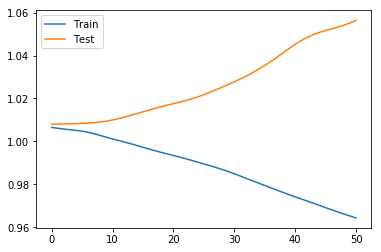

Run #3


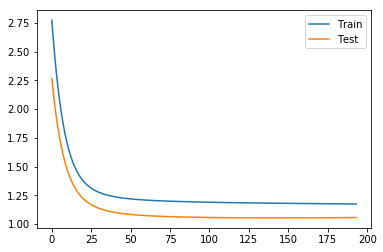

swp: 0/1 er_rel = 1.3e+02 er_abs = 9.6e+02 erank = 4.0 fun_eval: 660
swp: 1/1 er_rel = 3.2e-01 er_abs = 2.3e+00 erank = 6.0 fun_eval: 2360


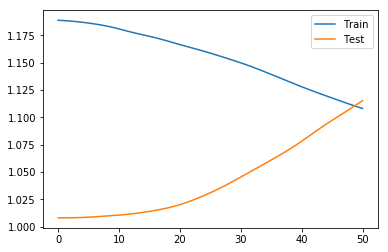

Run #4


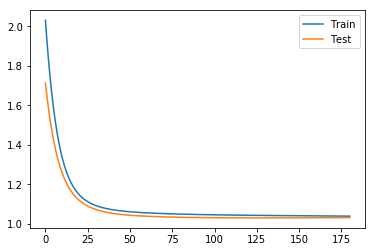

swp: 0/1 er_rel = 1.7e+02 er_abs = 1.0e+03 erank = 4.0 fun_eval: 660
swp: 1/1 er_rel = 6.0e-01 er_abs = 3.9e+00 erank = 6.0 fun_eval: 2360


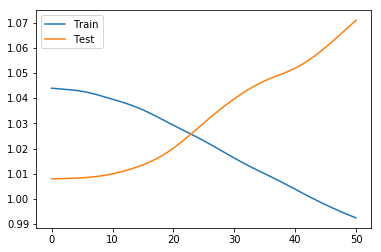

Run #5


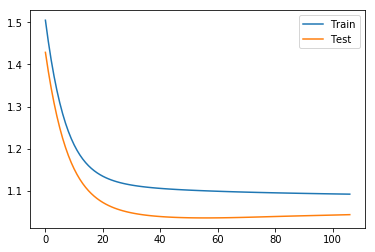

swp: 0/1 er_rel = 2.2e+02 er_abs = 1.4e+03 erank = 4.0 fun_eval: 660
swp: 1/1 er_rel = 3.4e-01 er_abs = 2.3e+00 erank = 6.2 fun_eval: 2370


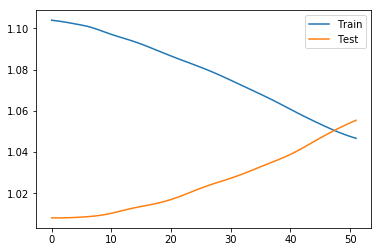

Run #6


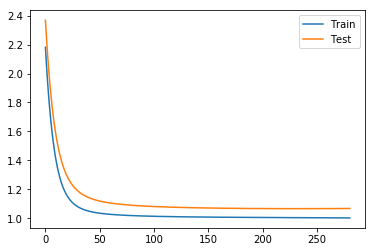

swp: 0/1 er_rel = 2.8e+02 er_abs = 2.0e+03 erank = 4.0 fun_eval: 660
swp: 1/1 er_rel = 4.3e-01 er_abs = 2.9e+00 erank = 6.0 fun_eval: 2360


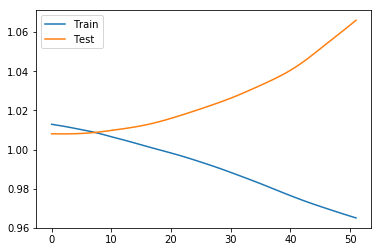

Run #7


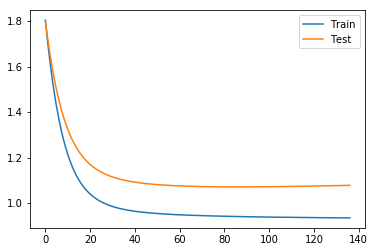

swp: 0/1 er_rel = 2.8e+02 er_abs = 1.4e+03 erank = 4.0 fun_eval: 660
swp: 1/1 er_rel = 5.6e-01 er_abs = 3.7e+00 erank = 6.2 fun_eval: 2370


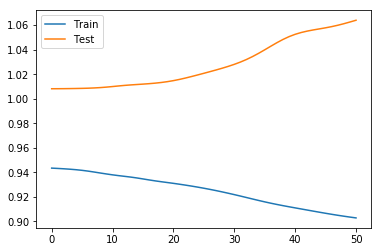

Run #8


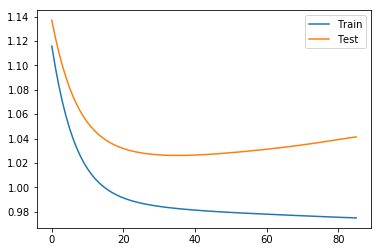

swp: 0/1 er_rel = 1.2e+02 er_abs = 8.2e+02 erank = 4.0 fun_eval: 660
swp: 1/1 er_rel = 3.9e-01 er_abs = 2.7e+00 erank = 6.0 fun_eval: 2360


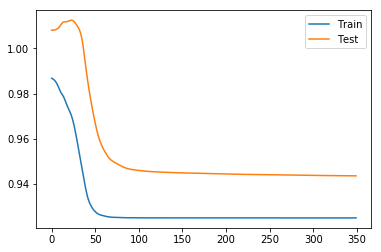

Run #9


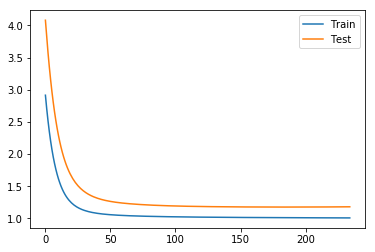

swp: 0/1 er_rel = 2.1e+02 er_abs = 1.4e+03 erank = 4.0 fun_eval: 660
swp: 1/1 er_rel = 4.4e-01 er_abs = 3.0e+00 erank = 6.0 fun_eval: 2360


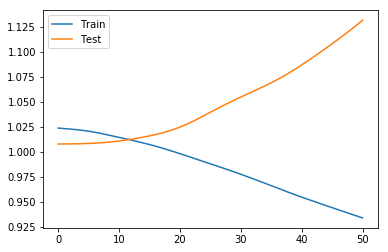

Rand:  1.0350719890293736 0.06300083693665448
GP:    1.0275502929128315 0.07244056244232597
Rand:  1.07613187673936 0.0394762864607315
GP:    1.0741008805719636 0.05596414367637237
Dim: 6
Run #0


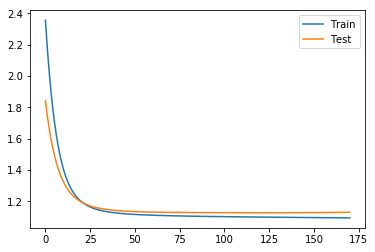

swp: 0/1 er_rel = 1.0e+03 er_abs = 4.7e+03 erank = 4.0 fun_eval: 840
swp: 1/1 er_rel = 5.3e-01 er_abs = 2.8e+00 erank = 6.1 fun_eval: 3050


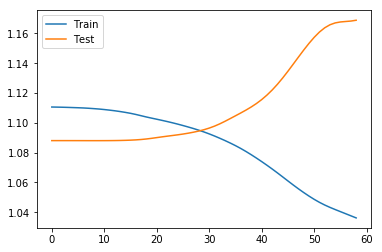

Run #1


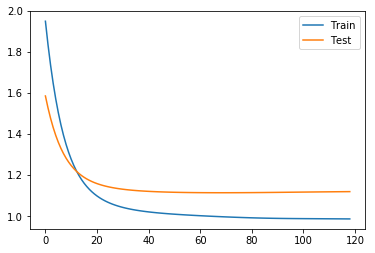

swp: 0/1 er_rel = 9.1e+02 er_abs = 3.7e+03 erank = 4.0 fun_eval: 840
swp: 1/1 er_rel = 8.0e-01 er_abs = 3.5e+00 erank = 6.4 fun_eval: 3100


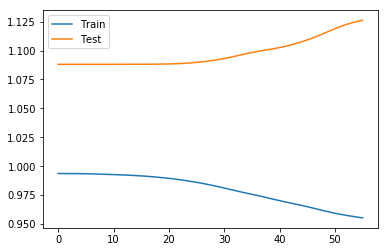

Run #2


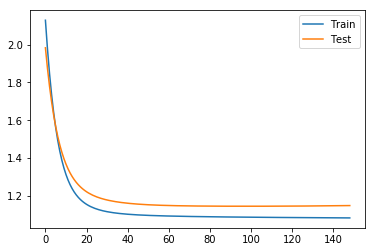

swp: 0/1 er_rel = 1.3e+03 er_abs = 5.8e+03 erank = 4.0 fun_eval: 840
swp: 1/1 er_rel = 6.6e-01 er_abs = 3.3e+00 erank = 6.1 fun_eval: 3110


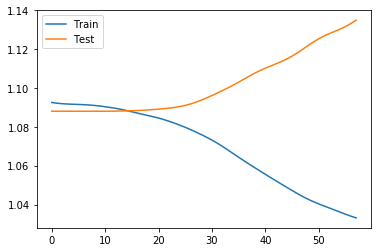

Run #3


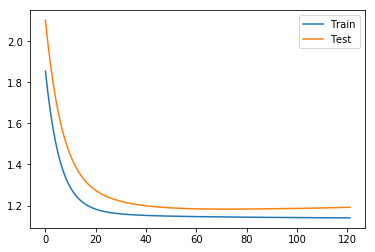

swp: 0/1 er_rel = 9.6e+02 er_abs = 4.1e+03 erank = 4.0 fun_eval: 840
swp: 1/1 er_rel = 6.4e-01 er_abs = 3.4e+00 erank = 6.2 fun_eval: 3090


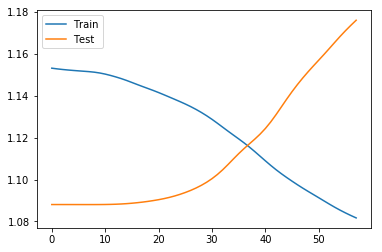

Run #4


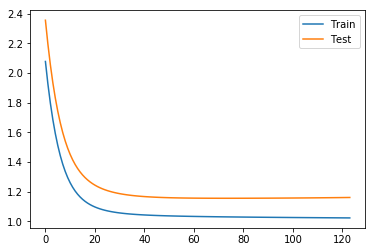

swp: 0/1 er_rel = 6.8e+02 er_abs = 3.5e+03 erank = 4.0 fun_eval: 840
swp: 1/1 er_rel = 7.3e-01 er_abs = 4.0e+00 erank = 6.4 fun_eval: 3270


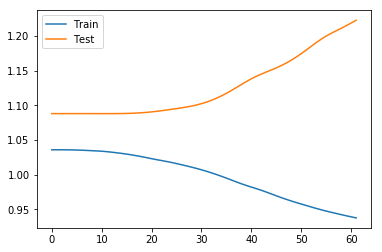

Run #5


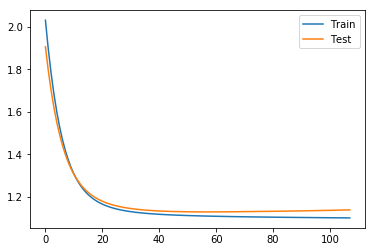

swp: 0/1 er_rel = 1.2e+03 er_abs = 5.6e+03 erank = 4.0 fun_eval: 840
swp: 1/1 er_rel = 5.7e-01 er_abs = 2.9e+00 erank = 6.1 fun_eval: 3110


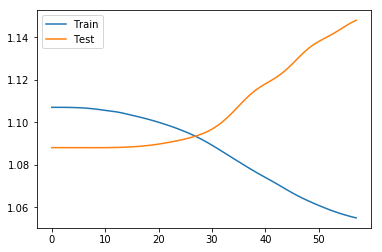

Run #6


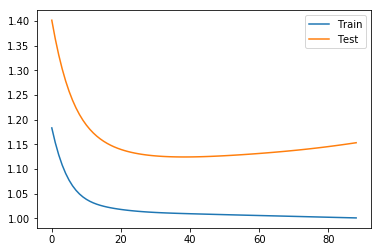

swp: 0/1 er_rel = 8.6e+02 er_abs = 4.2e+03 erank = 4.0 fun_eval: 840
swp: 1/1 er_rel = 6.2e-01 er_abs = 3.4e+00 erank = 6.0 fun_eval: 3040


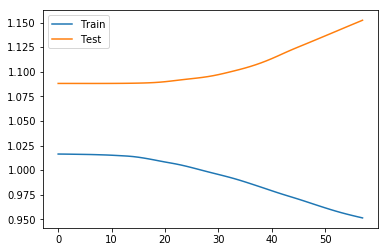

Run #7


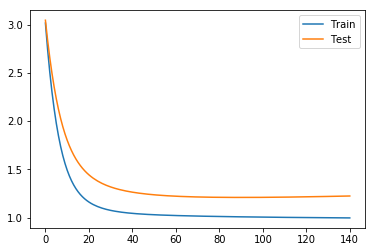

swp: 0/1 er_rel = 9.7e+02 er_abs = 3.5e+03 erank = 4.0 fun_eval: 840
swp: 1/1 er_rel = 6.5e-01 er_abs = 2.8e+00 erank = 6.2 fun_eval: 3190


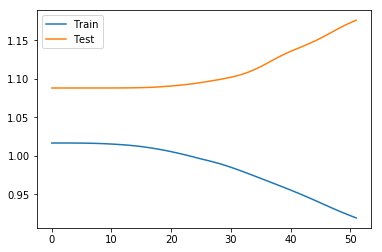

Run #8


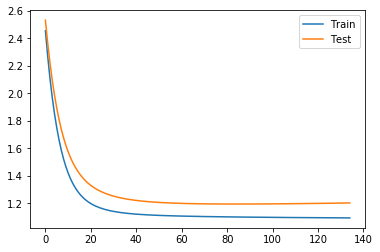

swp: 0/1 er_rel = 1.1e+03 er_abs = 5.0e+03 erank = 4.0 fun_eval: 840
swp: 1/1 er_rel = 7.3e-01 er_abs = 3.8e+00 erank = 6.6 fun_eval: 3150


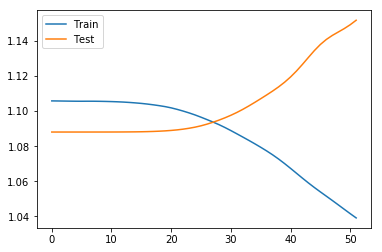

Run #9


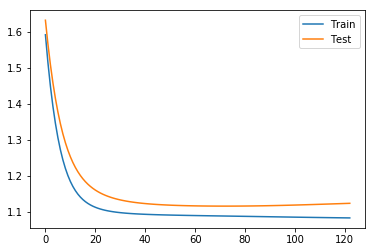

swp: 0/1 er_rel = 1.9e+03 er_abs = 7.6e+03 erank = 4.0 fun_eval: 840
swp: 1/1 er_rel = 7.8e-01 er_abs = 3.7e+00 erank = 6.2 fun_eval: 3090


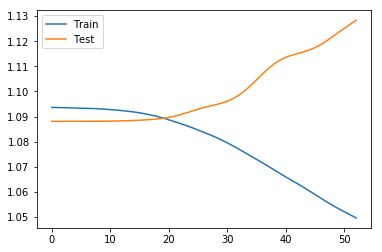

Rand:  1.0601074697187047 0.045386921570940986
GP:    1.00773281338607 0.058685949301880855
Rand:  1.1610270287347673 0.0351793865415962
GP:    1.1594518704932641 0.029099844406246043
Dim: 7
Run #0


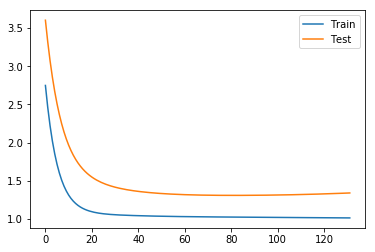

swp: 0/1 er_rel = 2.0e+03 er_abs = 1.6e+04 erank = 4.0 fun_eval: 1020
swp: 1/1 er_rel = 8.0e-01 er_abs = 7.0e+00 erank = 6.2 fun_eval: 3770


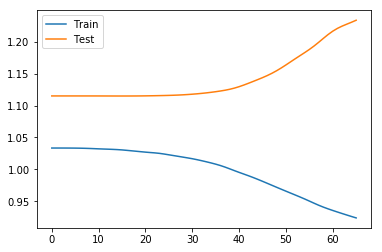

Run #1


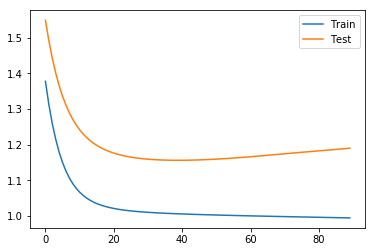

swp: 0/1 er_rel = 4.3e+03 er_abs = 2.9e+04 erank = 4.2 fun_eval: 1050
swp: 1/1 er_rel = 7.8e-01 er_abs = 6.4e+00 erank = 6.4 fun_eval: 4000


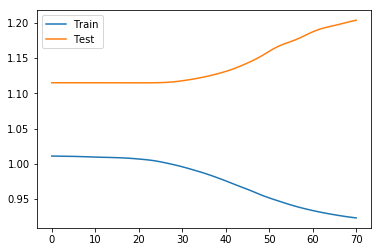

Run #2


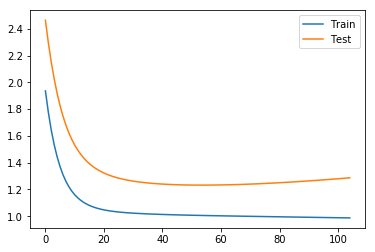

swp: 0/1 er_rel = 4.1e+03 er_abs = 2.8e+04 erank = 4.0 fun_eval: 1020
swp: 1/1 er_rel = 5.8e-01 er_abs = 4.4e+00 erank = 6.3 fun_eval: 3780


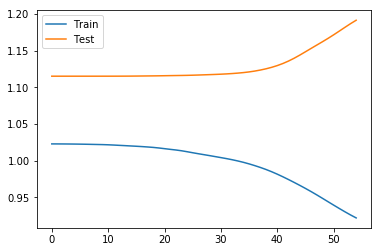

Run #3


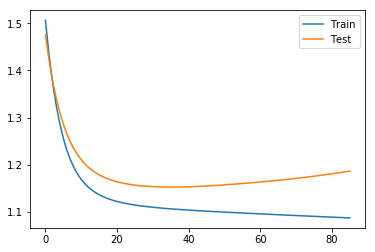

swp: 0/1 er_rel = 1.6e+03 er_abs = 1.1e+04 erank = 4.0 fun_eval: 1020
swp: 1/1 er_rel = 1.0e+00 er_abs = 8.7e+00 erank = 6.2 fun_eval: 3770


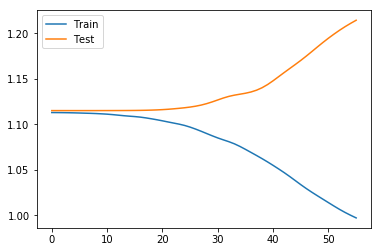

Run #4


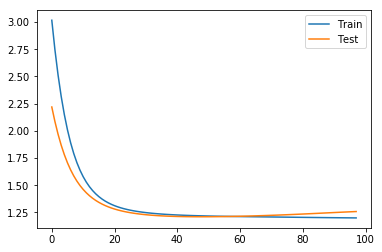

swp: 0/1 er_rel = 1.4e+03 er_abs = 9.4e+03 erank = 4.0 fun_eval: 1020
swp: 1/1 er_rel = 6.9e-01 er_abs = 5.7e+00 erank = 6.2 fun_eval: 3770


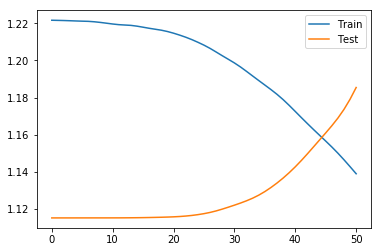

Run #5


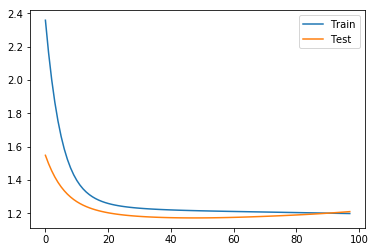

swp: 0/1 er_rel = 2.9e+03 er_abs = 1.9e+04 erank = 4.0 fun_eval: 1020
swp: 1/1 er_rel = 7.0e-01 er_abs = 5.9e+00 erank = 6.4 fun_eval: 3820


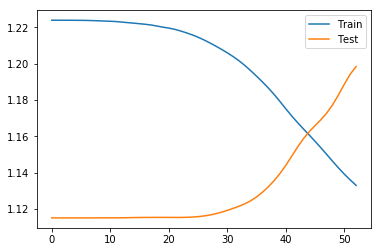

Run #6


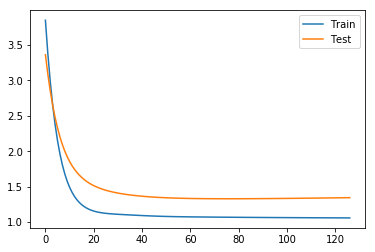

swp: 0/1 er_rel = 4.0e+03 er_abs = 2.9e+04 erank = 4.0 fun_eval: 1020
swp: 1/1 er_rel = 7.4e-01 er_abs = 6.1e+00 erank = 6.1 fun_eval: 3730


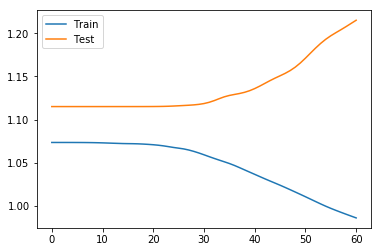

Run #7


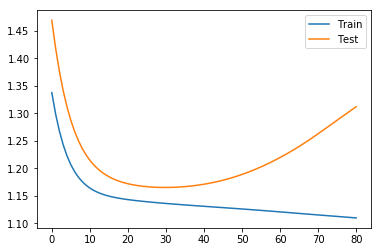

swp: 0/1 er_rel = 3.1e+03 er_abs = 2.5e+04 erank = 4.0 fun_eval: 1020
swp: 1/1 er_rel = 8.9e-01 er_abs = 7.6e+00 erank = 6.5 fun_eval: 3930


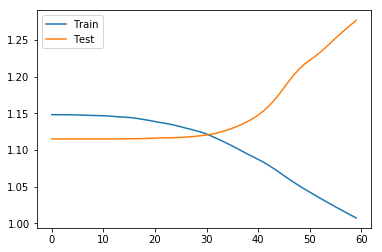

Run #8


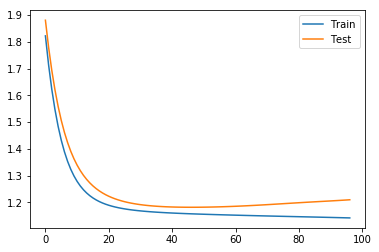

swp: 0/1 er_rel = 3.9e+03 er_abs = 2.7e+04 erank = 4.0 fun_eval: 1020
swp: 1/1 er_rel = 8.1e-01 er_abs = 7.0e+00 erank = 6.2 fun_eval: 3770


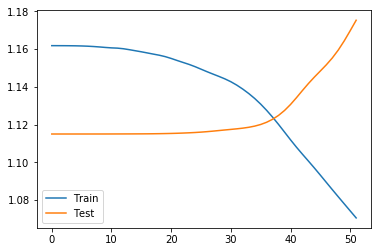

Run #9


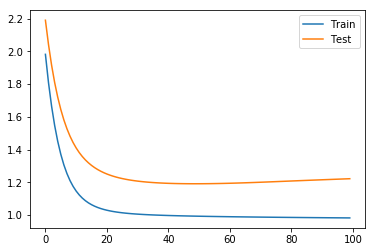

swp: 0/1 er_rel = 5.1e+03 er_abs = 2.9e+04 erank = 4.0 fun_eval: 1020
swp: 1/1 er_rel = 6.5e-01 er_abs = 4.8e+00 erank = 6.2 fun_eval: 3770


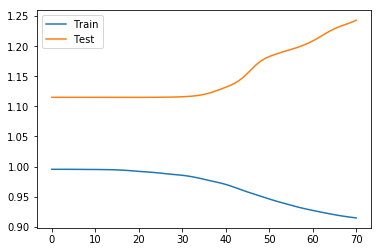

Rand:  1.0817334377433871 0.08526958051801121
GP:    1.031087069961264 0.09023006278492512
Rand:  1.2519234265184376 0.05788324233962562
GP:    1.213713980227773 0.02946278914278642
Dim: 8
Run #0


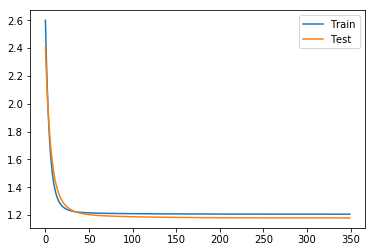

swp: 0/1 er_rel = 1.0e+04 er_abs = 1.2e+05 erank = 4.0 fun_eval: 1200
swp: 1/1 er_rel = 9.0e-01 er_abs = 1.1e+01 erank = 6.2 fun_eval: 4450


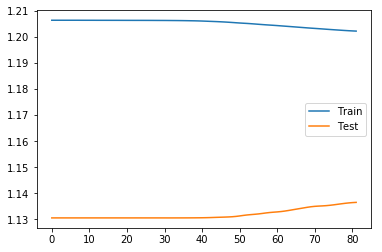

Run #1


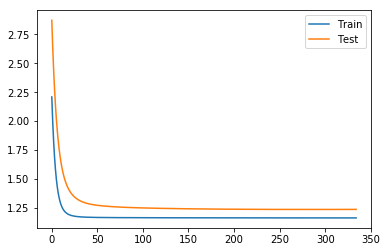

swp: 0/1 er_rel = 1.1e+04 er_abs = 1.5e+05 erank = 4.0 fun_eval: 1200
swp: 1/1 er_rel = 1.2e+00 er_abs = 1.7e+01 erank = 6.4 fun_eval: 4510


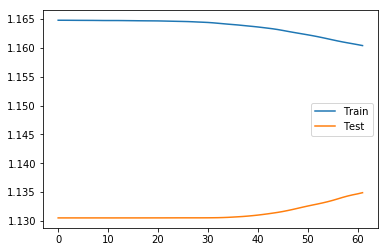

Run #2


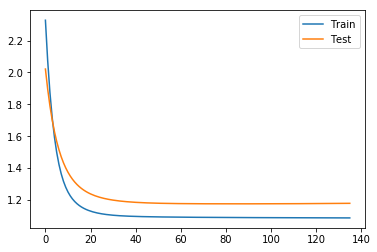

swp: 0/1 er_rel = 7.1e+03 er_abs = 7.4e+04 erank = 4.0 fun_eval: 1200
swp: 1/1 er_rel = 9.6e-01 er_abs = 1.3e+01 erank = 6.6 fun_eval: 4620


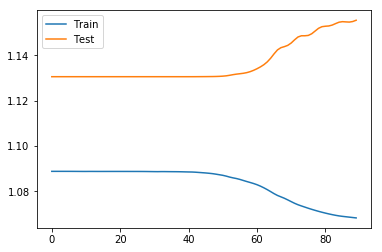

Run #3


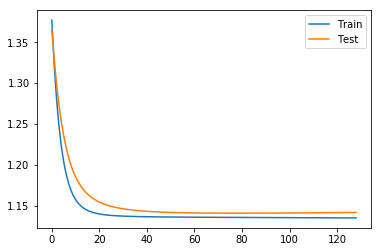

swp: 0/1 er_rel = 6.6e+03 er_abs = 7.6e+04 erank = 4.2 fun_eval: 1230
swp: 1/1 er_rel = 8.7e-01 er_abs = 1.4e+01 erank = 6.5 fun_eval: 4730


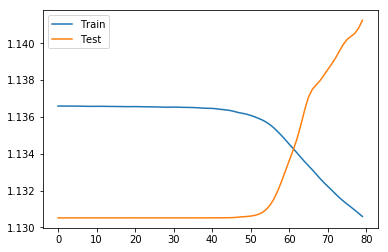

Run #4


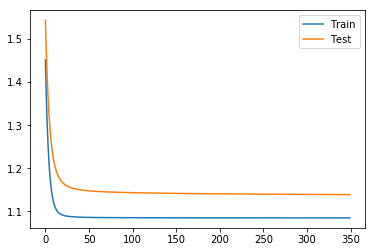

swp: 0/1 er_rel = 9.8e+03 er_abs = 1.0e+05 erank = 4.0 fun_eval: 1200
swp: 1/1 er_rel = 9.5e-01 er_abs = 1.5e+01 erank = 6.4 fun_eval: 4610


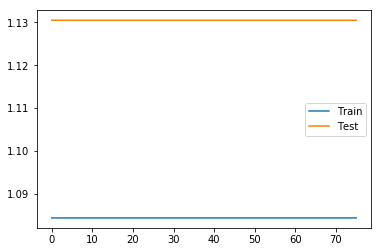

Run #5


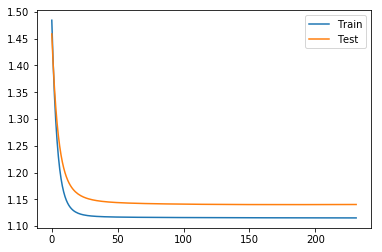

swp: 0/1 er_rel = 7.2e+03 er_abs = 8.5e+04 erank = 4.0 fun_eval: 1200
swp: 1/1 er_rel = 9.3e-01 er_abs = 1.3e+01 erank = 6.2 fun_eval: 4550


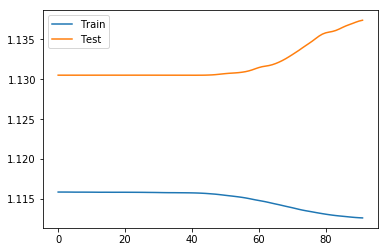

Run #6


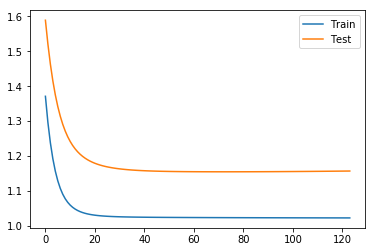

swp: 0/1 er_rel = 9.8e+03 er_abs = 9.1e+04 erank = 4.0 fun_eval: 1200
swp: 1/1 er_rel = 1.0e+00 er_abs = 1.3e+01 erank = 7.1 fun_eval: 4940


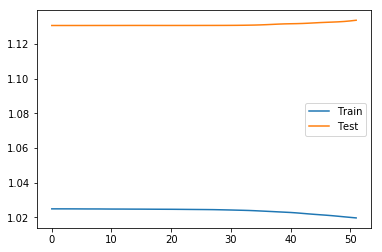

Run #7


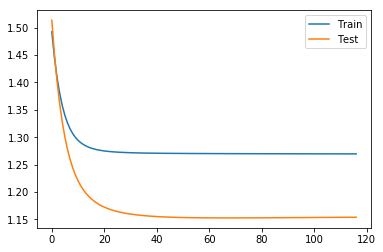

swp: 0/1 er_rel = 9.9e+03 er_abs = 9.9e+04 erank = 4.0 fun_eval: 1200
swp: 1/1 er_rel = 8.0e-01 er_abs = 1.1e+01 erank = 6.6 fun_eval: 4720


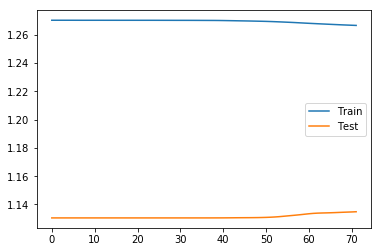

Run #8


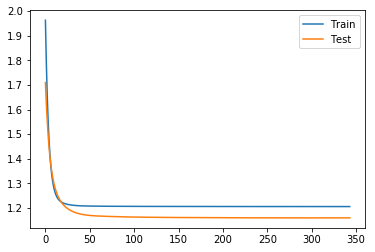

swp: 0/1 er_rel = 1.2e+04 er_abs = 1.1e+05 erank = 4.0 fun_eval: 1200
swp: 1/1 er_rel = 9.1e-01 er_abs = 1.2e+01 erank = 6.6 fun_eval: 4670


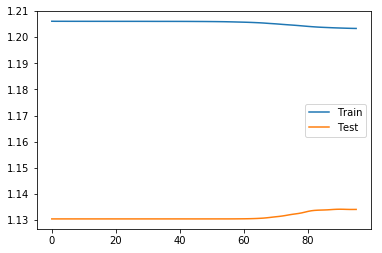

Run #9


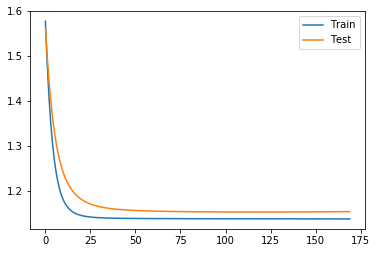

swp: 0/1 er_rel = 8.2e+03 er_abs = 1.1e+05 erank = 4.1 fun_eval: 1210
swp: 1/1 er_rel = 7.7e-01 er_abs = 1.3e+01 erank = 6.5 fun_eval: 4640


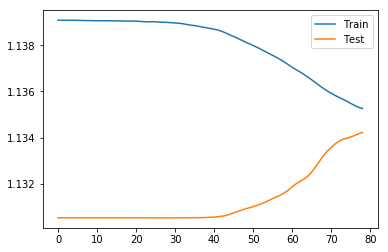

Rand:  1.1411868247174133 0.06838644104053557
GP:    1.1360703437481932 0.0703089829349296
Rand:  1.164456662357307 0.03071946145283128
GP:    1.1365464032162271 0.0034451003039444495
Dim: 9
Run #0


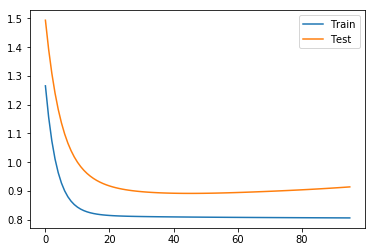

swp: 0/1 er_rel = 1.1e+05 er_abs = 9.2e+05 erank = 4.0 fun_eval: 1380
swp: 1/1 er_rel = 8.3e-01 er_abs = 9.1e+00 erank = 6.1 fun_eval: 5130


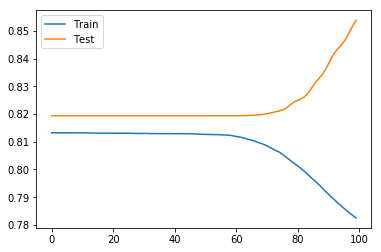

Run #1


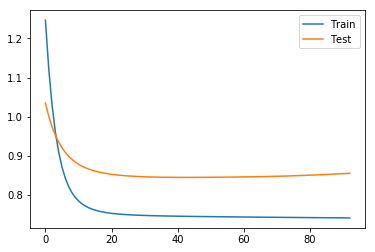

swp: 0/1 er_rel = 4.1e+04 er_abs = 3.7e+05 erank = 4.0 fun_eval: 1380
swp: 1/1 er_rel = 9.9e-01 er_abs = 1.1e+01 erank = 6.4 fun_eval: 5190


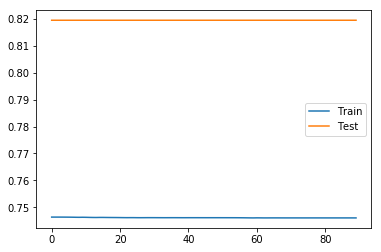

Run #2


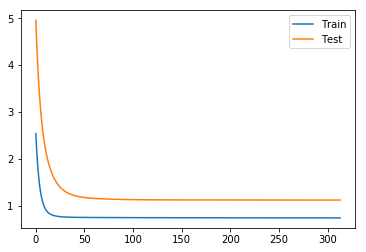

swp: 0/1 er_rel = 4.9e+04 er_abs = 4.0e+05 erank = 4.0 fun_eval: 1380
swp: 1/1 er_rel = 9.6e-01 er_abs = 9.2e+00 erank = 6.4 fun_eval: 5330


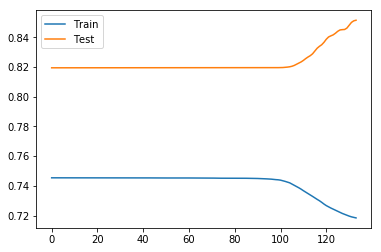

Run #3


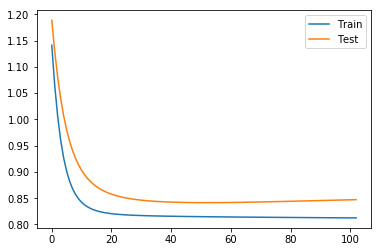

swp: 0/1 er_rel = 5.9e+04 er_abs = 4.6e+05 erank = 4.0 fun_eval: 1380
swp: 1/1 er_rel = 8.5e-01 er_abs = 7.9e+00 erank = 6.0 fun_eval: 5080


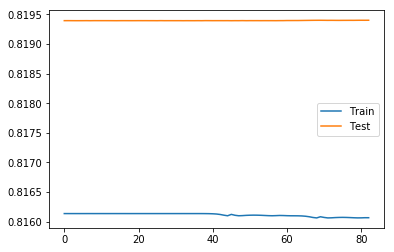

Run #4


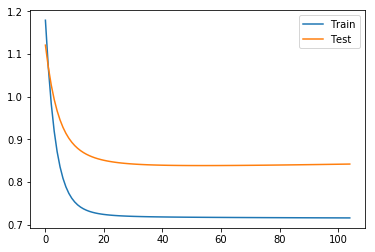

swp: 0/1 er_rel = 3.1e+04 er_abs = 2.6e+05 erank = 4.3 fun_eval: 1440
swp: 1/1 er_rel = 9.4e-01 er_abs = 1.0e+01 erank = 6.6 fun_eval: 5650


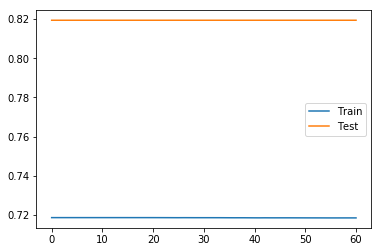

Run #5


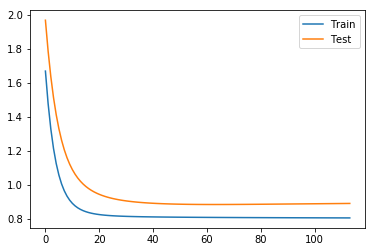

swp: 0/1 er_rel = 3.9e+04 er_abs = 3.9e+05 erank = 4.0 fun_eval: 1380
swp: 1/1 er_rel = 9.8e-01 er_abs = 1.1e+01 erank = 6.0 fun_eval: 5080


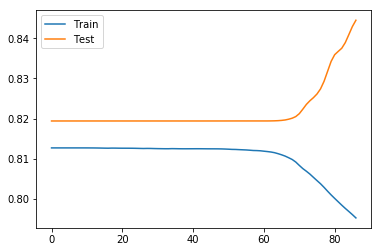

Run #6


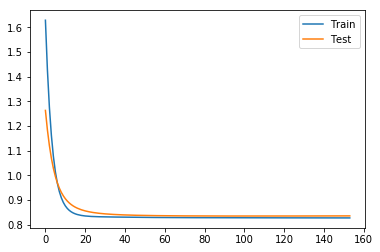

swp: 0/1 er_rel = 3.6e+04 er_abs = 2.9e+05 erank = 4.0 fun_eval: 1380
swp: 1/1 er_rel = 8.2e-01 er_abs = 8.9e+00 erank = 6.4 fun_eval: 5230


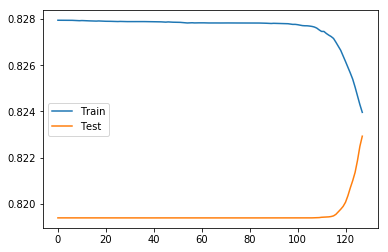

Run #7


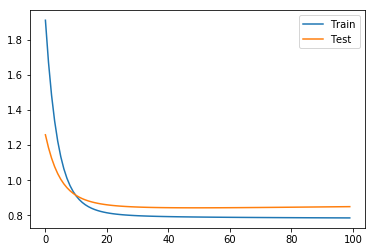

swp: 0/1 er_rel = 4.3e+04 er_abs = 4.6e+05 erank = 4.0 fun_eval: 1380
swp: 1/1 er_rel = 1.0e+00 er_abs = 1.3e+01 erank = 6.6 fun_eval: 5510


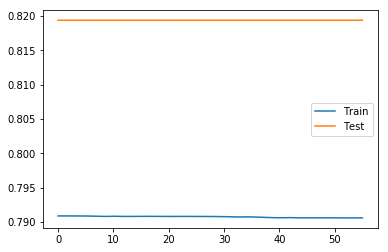

Run #8


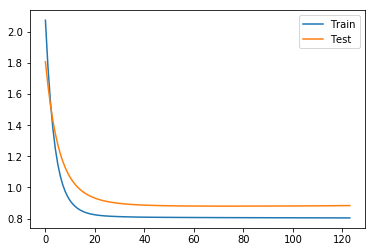

swp: 0/1 er_rel = 8.0e+04 er_abs = 7.5e+05 erank = 4.0 fun_eval: 1380
swp: 1/1 er_rel = 8.1e-01 er_abs = 7.8e+00 erank = 6.1 fun_eval: 5230


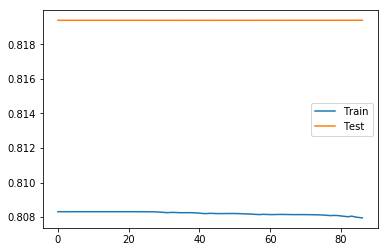

Run #9


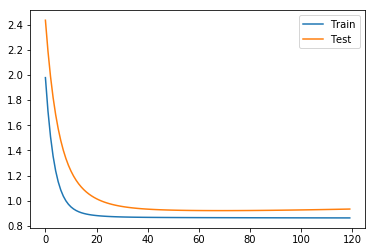

swp: 0/1 er_rel = 6.9e+04 er_abs = 6.8e+05 erank = 4.0 fun_eval: 1380
swp: 1/1 er_rel = 1.0e+00 er_abs = 1.3e+01 erank = 6.1 fun_eval: 5130


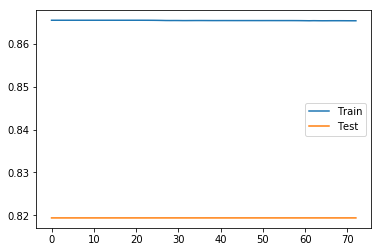

Rand:  0.7911066143475773 0.04124442257581989
GP:    0.7879129227567548 0.044373768197252014
Rand:  0.8995820338786638 0.08656340868784528
GP:    0.827050870228026 0.012097790669595801
Dim: 10
Run #0


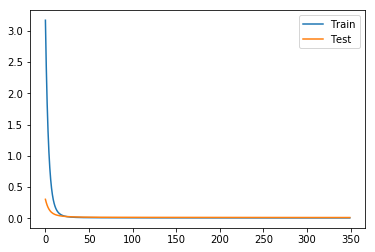

swp: 0/1 er_rel = 2.6e+09 er_abs = 8.0e+05 erank = 4.0 fun_eval: 1560
swp: 1/1 er_rel = 1.3e-05 er_abs = 4.1e-09 erank = 6.8 fun_eval: 6290


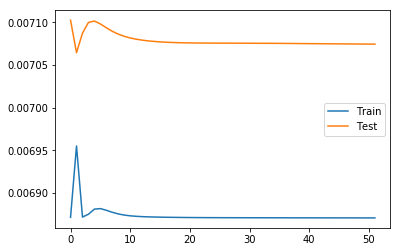

Run #1


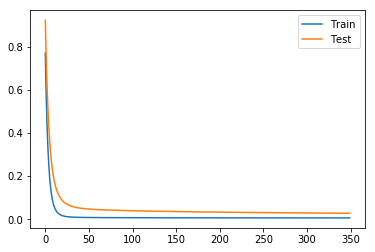

swp: 0/1 er_rel = 4.1e+10 er_abs = 1.2e+06 erank = 4.0 fun_eval: 1560
swp: 1/1 er_rel = 8.3e-03 er_abs = 2.5e-07 erank = 6.4 fun_eval: 5910


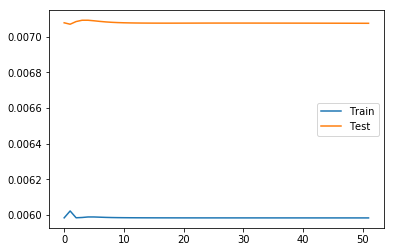

Run #2


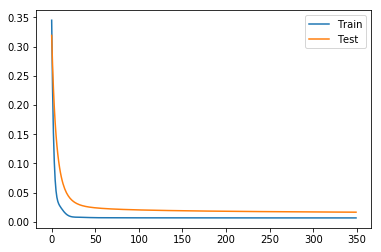

 /home/yeahrmek/miniconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 /home/yeahrmek/miniconda3/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:overflow encountered in square
 /home/yeahrmek/miniconda3/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:invalid value encountered in multiply


swp: 0/1 er_rel = 3.4e+07 er_abs = 9.3e+05 erank = 4.0 fun_eval: 1560
swp: 1/1 er_rel = 1.7e-01 er_abs = 4.5e-03 erank = 6.9 fun_eval: 6340


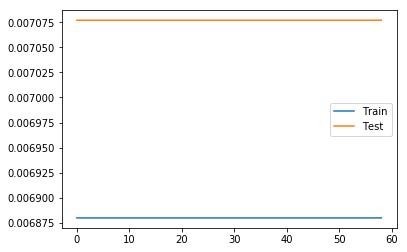

Run #3


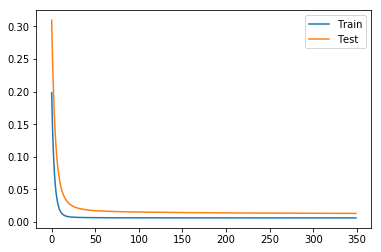

swp: 0/1 er_rel = 2.2e+08 er_abs = 2.4e+06 erank = 4.0 fun_eval: 1560
swp: 1/1 er_rel = 1.0e+00 er_abs = 1.8e-02 erank = 6.0 fun_eval: 5760


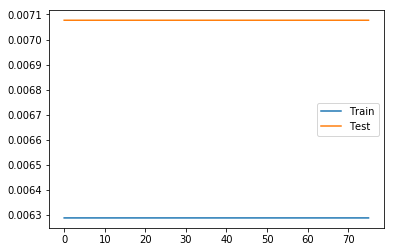

Run #4


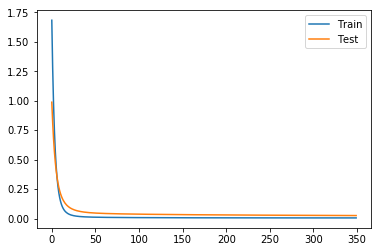

swp: 0/1 er_rel = 2.1e+08 er_abs = 1.7e+06 erank = 4.0 fun_eval: 1560
swp: 1/1 er_rel = 2.8e-03 er_abs = 2.3e-05 erank = 6.2 fun_eval: 5860


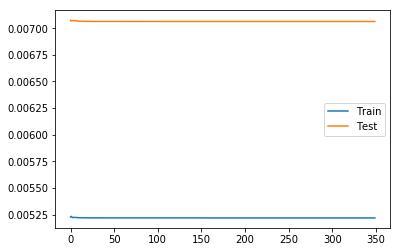

Run #5


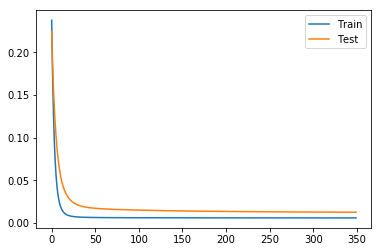

swp: 0/1 er_rel = 5.7e+03 er_abs = 1.1e+06 erank = 4.0 fun_eval: 1560
swp: 1/1 er_rel = 2.3e-04 er_abs = 4.4e-02 erank = 6.7 fun_eval: 6170


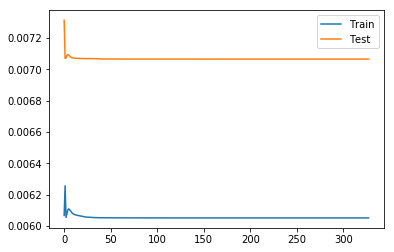

Run #6


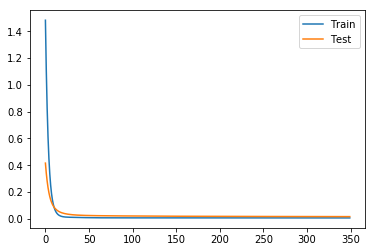

swp: 0/1 er_rel = 2.3e+07 er_abs = 1.5e+06 erank = 4.0 fun_eval: 1560
swp: 1/1 er_rel = 1.9e-05 er_abs = 1.3e-06 erank = 7.2 fun_eval: 6720


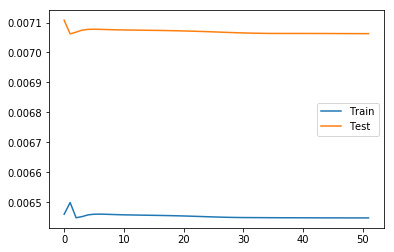

Run #7


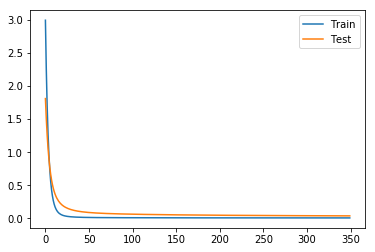

swp: 0/1 er_rel = 1.6e+09 er_abs = 2.0e+06 erank = 4.0 fun_eval: 1560
swp: 1/1 er_rel = 1.8e-03 er_abs = 2.1e-06 erank = 6.1 fun_eval: 5810


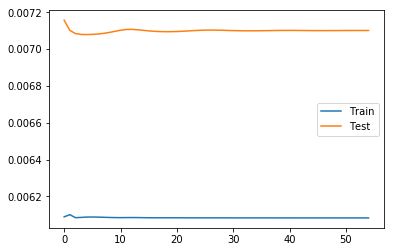

Run #8


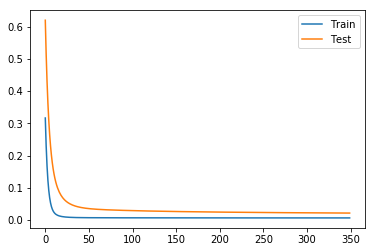

swp: 0/1 er_rel = 7.2e+07 er_abs = 1.9e+06 erank = 4.0 fun_eval: 1560
swp: 1/1 er_rel = 1.0e+00 er_abs = 3.2e-02 erank = 6.0 fun_eval: 5760


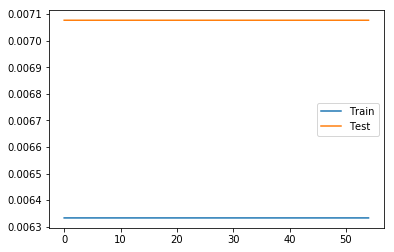

Run #9


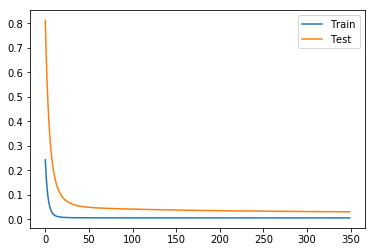

swp: 0/1 er_rel = 5.9e+201 er_abs = 1.3e+06 erank = 4.0 fun_eval: 1560
swp: 1/1 er_rel = 1.0e+00 er_abs = 2.1e-156 erank = 6.0 fun_eval: 5760


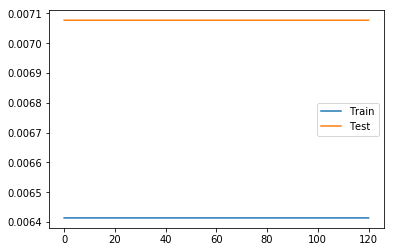

Rand:  0.006405698972369018 0.00042173471597493374
GP:    0.006256393234082523 0.00045339158800066875
Rand:  0.021477063686109927 0.008242816486677943
GP:    0.007073843430698215 1.0211688028128393e-05


In [13]:
d_list = range(3, 11)
r_list = [2] * len(d_list)
train_size_default = 500

n_runs = 10

random_state = np.random.RandomState(42)

errors_rand = {'mse_train': [], 'mse_test': [], 'rel_train': [], 'rel_test': []}
errors_gp = {'mse_train': [], 'mse_test': [], 'rel_train': [], 'rel_test': [],
             'model_mse_train': [], 'model_mse_test': [],
             'init_mse_train': [], 'init_mse_test': []}


for i, d in enumerate(d_list):

    print('Dim: {}'.format(d))

    # generate problem and training and test sets
    model_gp = generate_exact_gp_model(d, random_state, ARD=False)
    size = [10 for i in range(d)]
    train_size = min(train_size_default, np.prod(size))
    
    test_idx = random_state.randint(10**d, size=(5000))
    test_idx = idx2multiidx(test_idx, size)
    x_test = test_idx / (np.asarray(size) - 1)
    y_test, _ = model_gp.predict(x_test)
    
    for run_counter in range(n_runs):
        print("Run #{}".format(run_counter))

        x_train, y_train = get_data(model_gp, train_size, size, random_state)
        train_idx = (x_train * (np.asarray(size) - 1)).astype(int)

        # Make tensor completion using random init
        results_rand = tensor_completion_rand_init(y_train, train_idx, y_test, test_idx, size)

        
        # Make tensor completion using KRR+TT-cross as init
        results_gp = tensor_completion_gp_init(x_train, y_train, train_idx, y_test, test_idx, size)

        gp = results_gp[2]
        x_gp = results_gp[3]
        for i, mode in enumerate(['train', 'test']):
            errors_rand['mse_' + mode].append(results_rand[i])
            errors_rand['rel_' + mode].append(np.sqrt(results_rand[i]) / y_test.std())

            errors_gp['mse_' + mode].append(results_gp[i])
            errors_gp['rel_' + mode].append(np.sqrt(results_gp[i]) / y_test.std())

            if mode == 'train':
                gp_pr = gp.predict(x_train)[0]
                y_truth = y_train
                indices_truth = train_idx
            else:
                gp_pr = gp.predict(x_test)[0]
                y_truth = y_test
                indices_truth = test_idx

            errors_gp['model_mse_' + mode].append(mean_squared_error(y_truth, gp_pr))
            errors_gp['init_mse_' + mode].append(calc_mse(y_truth, x_gp, indices_truth))
            
    for mode in ['train', 'test']:
        err_rand = errors_rand['mse_' + mode][-n_runs:]
        err_gp = errors_gp['mse_' + mode][-n_runs:]
        print('Rand: ', np.mean(err_rand), np.std(err_rand))
        print('GP:   ', np.mean(err_gp), np.std(err_gp))

for key in errors_rand:
    errors_rand[key] = np.array(errors_rand[key]).reshape(len(d_list), n_runs)
    
for key in errors_gp:
    errors_gp[key] = np.array(errors_gp[key]).reshape(len(d_list), n_runs)

In [15]:
import pickle
suffix = 'nruns={}'.format(n_runs)
with open('TensorCompletion_toy_problem_errors_rand_{}.pkl'.format(suffix), 'wb') as f:
    pickle.dump(errors_rand, f)

with open('TensorCompletion_toy_problem_errors_gpinit_{}.pkl'.format(suffix), 'wb') as f:
    pickle.dump(errors_gp, f)

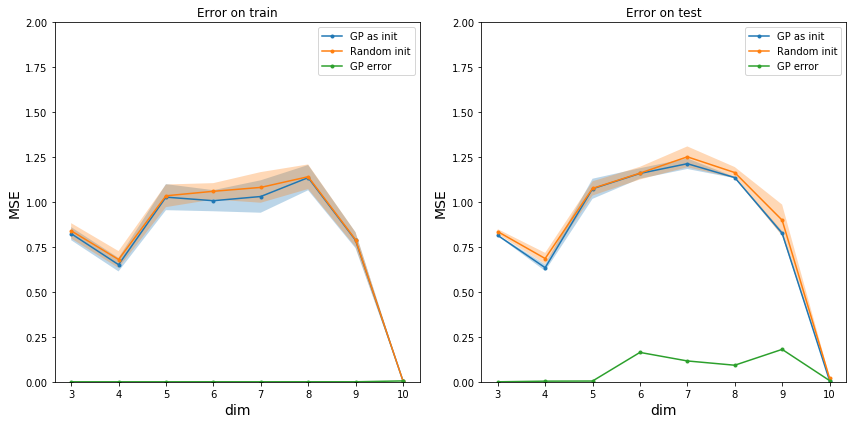

In [17]:
figure = pyplot.figure(figsize=(12, 6))
for i, mode in enumerate(['train', 'test']):
    
    key = 'mse_' + mode
    
    def get_err_std(errors):
        return errors.mean(axis=1), errors.std(axis=1)
    
    
    err_krr, std_krr = get_err_std(errors_gp[key])
    err_rand, std_rand = get_err_std(errors_rand[key])
    
    ax = figure.add_subplot(1, 2, i + 1)
    ax.plot(d_list, err_krr, '.-', label='GP as init')
    ax.fill_between(d_list, err_krr - std_krr, err_krr + std_krr, alpha=0.3)
    
    ax.plot(d_list, err_rand, '.-', label='Random init')
    ax.fill_between(d_list, err_rand - std_rand, err_rand + std_rand, alpha=0.3)
    ax.plot(d_list, errors_gp['model_mse_' + mode].mean(axis=1), '.-', label='GP error')
    ax.legend(loc='best')
    ax.set_ylim([0, 2])
    ax.set_xlabel('dim', fontsize=14)
    ax.set_ylabel('MSE', fontsize=14)
    ax.set_title('Error on {}'.format(mode))
figure.tight_layout()
pyplot.show()

### Larger train size

Dim: 4
Run #0


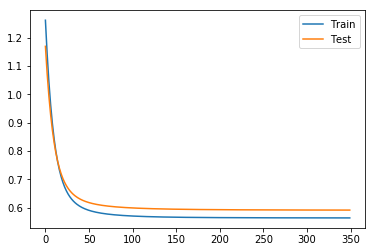

swp: 0/1 er_rel = 1.2e+02 er_abs = 3.3e+02 erank = 4.0 fun_eval: 480
swp: 1/1 er_rel = 6.0e-03 er_abs = 1.8e-02 erank = 6.0 fun_eval: 1680


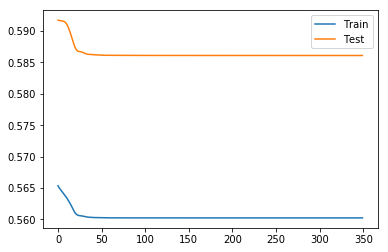

Rand:  0.5645132886707074 0.0
GP:    0.5602511032065438 0.0
Rand:  0.5917085711260671 0.0
GP:    0.5860360807515584 0.0
Dim: 5
Run #0


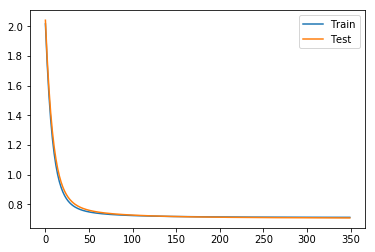

swp: 0/1 er_rel = 2.6e+02 er_abs = 1.0e+03 erank = 4.0 fun_eval: 660
swp: 1/1 er_rel = 4.4e-01 er_abs = 1.9e+00 erank = 6.0 fun_eval: 2360


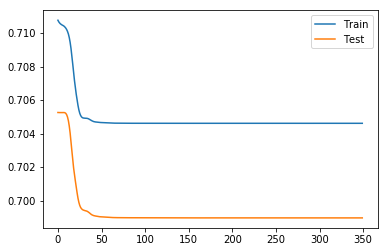

Rand:  0.7113815696993016 0.0
GP:    0.704606004241181 0.0
Rand:  0.7095462739102554 0.0
GP:    0.6988770363269432 0.0
Dim: 6
Run #0


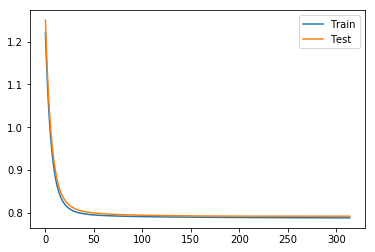

swp: 0/1 er_rel = 6.9e+02 er_abs = 5.8e+03 erank = 4.0 fun_eval: 840
swp: 1/1 er_rel = 6.6e-01 er_abs = 6.5e+00 erank = 6.2 fun_eval: 3090


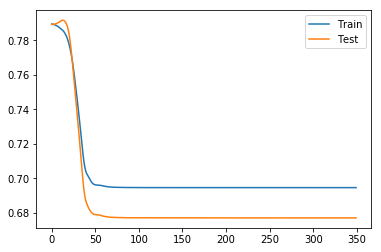

Rand:  0.789155055467195 0.0
GP:    0.6947393692713862 0.0
Rand:  0.7910620902698474 0.0
GP:    0.6772287066781892 0.0
Dim: 7
Run #0


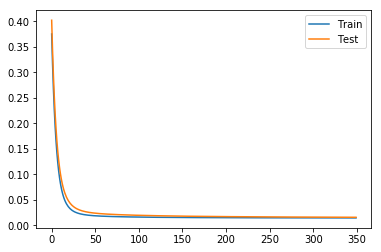

swp: 0/1 er_rel = 3.2e+05 er_abs = 3.0e+04 erank = 4.0 fun_eval: 1020
swp: 1/1 er_rel = 8.2e-01 er_abs = 1.1e-01 erank = 6.2 fun_eval: 3770


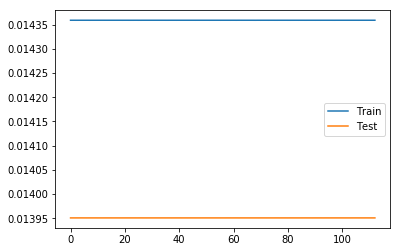

Rand:  0.014532508059259805 0.0
GP:    0.014359050290572285 0.0
Rand:  0.01579846408814653 0.0
GP:    0.01395074780719116 0.0
Dim: 8
Run #0


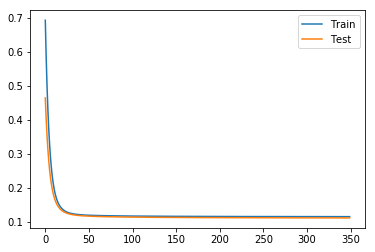

swp: 0/1 er_rel = 1.2e+05 er_abs = 1.0e+05 erank = 4.0 fun_eval: 1200
swp: 1/1 er_rel = 8.4e-01 er_abs = 8.7e-01 erank = 6.2 fun_eval: 4450


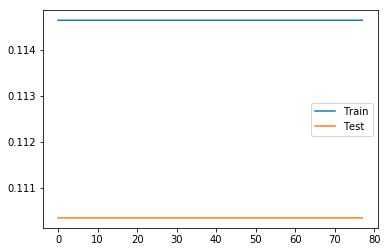

Rand:  0.11506675668699094 0.0
GP:    0.11462694206375597 0.0
Rand:  0.1114041653832282 0.0
GP:    0.11035567507902429 0.0
Dim: 9
Run #0


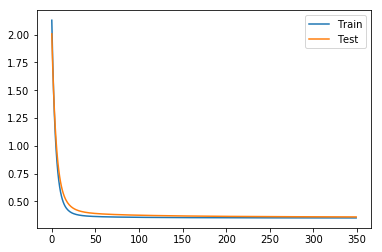

swp: 0/1 er_rel = 1.7e+05 er_abs = 4.8e+05 erank = 4.0 fun_eval: 1380
swp: 1/1 er_rel = 1.1e+00 er_abs = 4.2e+00 erank = 6.2 fun_eval: 5240


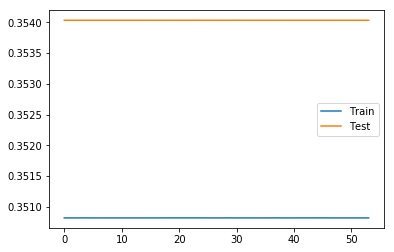

Rand:  0.35156400973596724 0.0
GP:    0.3508152382487546 0.0
Rand:  0.3633761977533801 0.0
GP:    0.35403400327728474 0.0


In [22]:
d_list = range(4, 10)
r_list = [2] * len(d_list)
train_size_default = 5000

n_runs = 1

random_state = np.random.RandomState(42)

errors_rand = {'mse_train': [], 'mse_test': [], 'rel_train': [], 'rel_test': []}
errors_gp = {'mse_train': [], 'mse_test': [], 'rel_train': [], 'rel_test': [],
             'model_mse_train': [], 'model_mse_test': [],
             'init_mse_train': [], 'init_mse_test': []}


for i, d in enumerate(d_list):

    print('Dim: {}'.format(d))

    # generate problem and training and test sets
    model_gp = generate_exact_gp_model(d, random_state, ARD=False)
    size = [10 for i in range(d)]
    train_size = min(train_size_default, np.prod(size))
    
    test_idx = random_state.randint(10**d, size=(5000))
    test_idx = idx2multiidx(test_idx, size)
    x_test = test_idx / (np.asarray(size) - 1)
    y_test, _ = model_gp.predict(x_test)
    
    for run_counter in range(n_runs):
        print("Run #{}".format(run_counter))

        x_train, y_train = get_data(model_gp, train_size, size, random_state)
        train_idx = (x_train * (np.asarray(size) - 1)).astype(int)

        # Make tensor completion using random init
        results_rand = tensor_completion_rand_init(y_train, train_idx, y_test, test_idx, size)

        
        # Make tensor completion using KRR+TT-cross as init
        results_gp = tensor_completion_gp_init(x_train, y_train, train_idx, y_test, test_idx, size)

        gp = results_gp[2]
        x_gp = results_gp[3]
        for i, mode in enumerate(['train', 'test']):
            errors_rand['mse_' + mode].append(results_rand[i])
            errors_rand['rel_' + mode].append(np.sqrt(results_rand[i]) / y_test.std())

            errors_gp['mse_' + mode].append(results_gp[i])
            errors_gp['rel_' + mode].append(np.sqrt(results_gp[i]) / y_test.std())

            if mode == 'train':
                gp_pr = gp.predict(x_train)[0]
                y_truth = y_train
                indices_truth = train_idx
            else:
                gp_pr = gp.predict(x_test)[0]
                y_truth = y_test
                indices_truth = test_idx

            errors_gp['model_mse_' + mode].append(mean_squared_error(y_truth, gp_pr))
            errors_gp['init_mse_' + mode].append(calc_mse(y_truth, x_gp, indices_truth))
            
    for mode in ['train', 'test']:
        err_rand = errors_rand['mse_' + mode][-n_runs:]
        err_gp = errors_gp['mse_' + mode][-n_runs:]
        print('Rand: ', np.mean(err_rand), np.std(err_rand))
        print('GP:   ', np.mean(err_gp), np.std(err_gp))

for key in errors_rand:
    errors_rand[key] = np.array(errors_rand[key]).reshape(len(d_list), n_runs)
    
for key in errors_gp:
    errors_gp[key] = np.array(errors_gp[key]).reshape(len(d_list), n_runs)

In [23]:
import pickle
suffix = 'nruns={}_train_size={}'.format(n_runs, train_size)
with open('TensorCompletion_toy_problem_errors_rand_{}.pkl'.format(suffix), 'wb') as f:
    pickle.dump(errors_rand, f)

with open('TensorCompletion_toy_problem_errors_gp_{}.pkl'.format(suffix), 'wb') as f:
    pickle.dump(errors_gp, f)

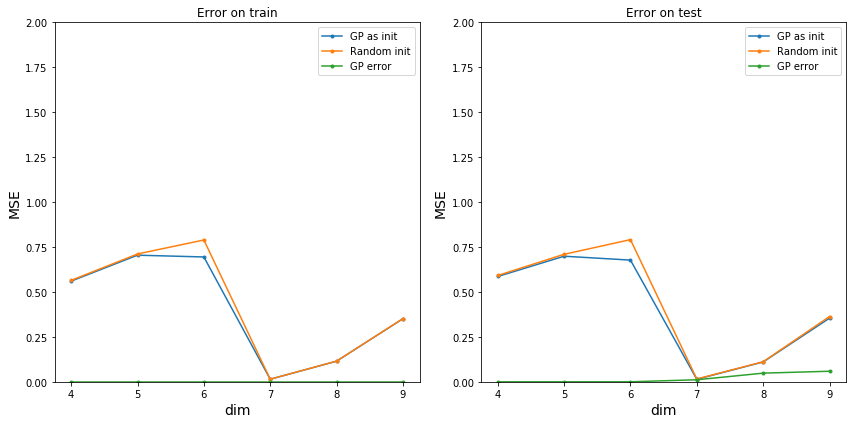

In [24]:
figure = pyplot.figure(figsize=(12, 6))
for i, mode in enumerate(['train', 'test']):
    
    key = 'mse_' + mode
    
    def get_err_std(errors):
        return errors.mean(axis=1), errors.std(axis=1)
    
    
    err_krr, std_krr = get_err_std(errors_gp[key])
    err_rand, std_rand = get_err_std(errors_rand[key])
    
    ax = figure.add_subplot(1, 2, i + 1)
    ax.plot(d_list, err_krr, '.-', label='GP as init')
    ax.fill_between(d_list, err_krr - std_krr, err_krr + std_krr, alpha=0.3)
    
    ax.plot(d_list, err_rand, '.-', label='Random init')
    ax.fill_between(d_list, err_rand - std_rand, err_rand + std_rand, alpha=0.3)
    ax.plot(d_list, errors_gp['model_mse_' + mode].mean(axis=1), '.-', label='GP error')
    ax.legend(loc='best')
    ax.set_ylim([0, 2])
    ax.set_xlabel('dim', fontsize=14)
    ax.set_ylabel('MSE', fontsize=14)
    ax.set_title('Error on {}'.format(mode))
figure.tight_layout()
pyplot.show()

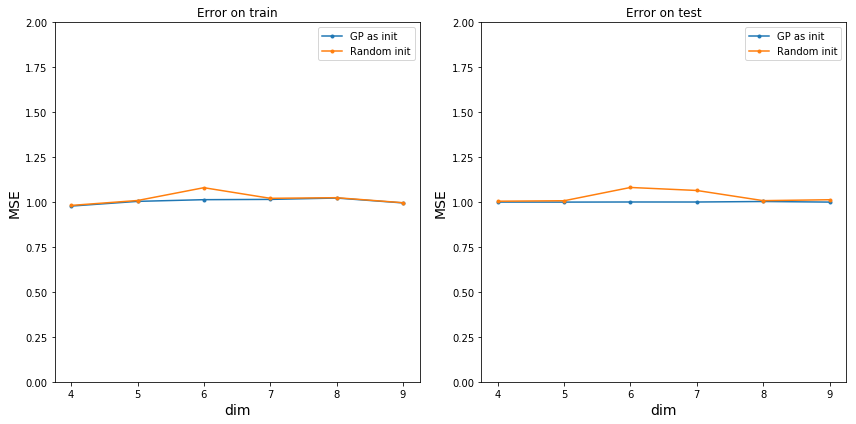

In [48]:
figure = pyplot.figure(figsize=(12, 6))
for i, mode in enumerate(['train', 'test']):
    
    key = 'rel_' + mode
    
    def get_err_std(errors):
        return errors.mean(axis=1), errors.std(axis=1)
    
    
    err_krr, std_krr = get_err_std(errors_gp[key])
    err_rand, std_rand = get_err_std(errors_rand[key])
    
    ax = figure.add_subplot(1, 2, i + 1)
    ax.plot(d_list, err_krr, '.-', label='GP as init')
    ax.fill_between(d_list, err_krr - std_krr, err_krr + std_krr, alpha=0.3)
    
    ax.plot(d_list, err_rand, '.-', label='Random init')
    ax.fill_between(d_list, err_rand - std_rand, err_rand + std_rand, alpha=0.3)
#     ax.plot(d_list, errors_gp['model_rel_' + mode].mean(axis=1), '.-', label='GP error')
    ax.legend(loc='best')
    ax.set_ylim([0, 2])
    ax.set_xlabel('dim', fontsize=14)
    ax.set_ylabel('MSE', fontsize=14)
    ax.set_title('Error on {}'.format(mode))
figure.tight_layout()
pyplot.show()

### Plot 2d slices

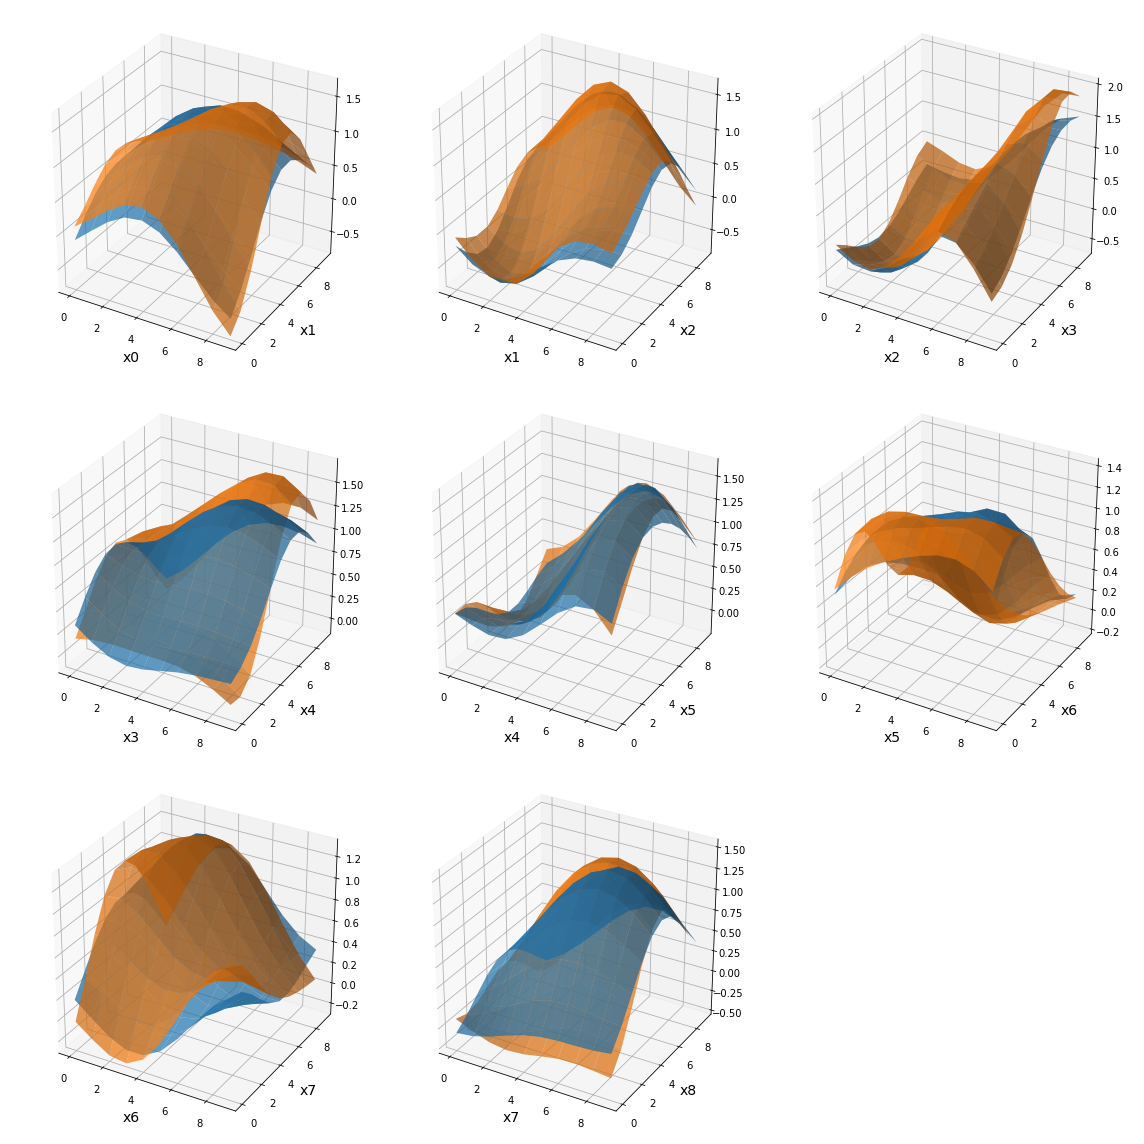

In [41]:
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)

d = x_train.shape[1]
n = 10

value = np.random.randint(n, size=(1, d))

figure = pyplot.figure(figsize=(16, 16))
m = int(np.sqrt(d))

for i in range(d):
    for j in range(i + 1, min(i + 2, d)):
        idx = [i, j]

        plot_size = n
        dim = 2

        x0 = np.tile(value, (plot_size**dim, 1))
        XY = np.meshgrid(np.arange(n), np.arange(n))
        x_grid = np.hstack([XY[0].reshape(-1, 1), XY[1].reshape(-1, 1)])
        x0[:, idx] = x_grid
        
        y_exact, _ = model_gp.predict(x0 / (n - 1))
        y_pr, _ = gp.predict(x0 / (n - 1))

        ax = figure.add_subplot(m, m, i + 1, projection='3d')
        ax.plot_surface(XY[0], XY[1], y_pr.reshape(plot_size, plot_size), alpha=0.7)
        ax.plot_surface(XY[0], XY[1], y_exact.reshape(plot_size, plot_size), alpha=0.7)
        
        ax.set_xlabel('x{}'.format(i), fontsize=14)
        ax.set_ylabel('x{}'.format(j), fontsize=14)
figure.tight_layout()
pyplot.show()